Import Statements

In [1]:
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline

Get the past 10 years of stock price close data for Proctor & Gamble

In [2]:
ticker = 'PG' 
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2010-1-1')['Adj Close']

Estimate historical log returns

In [3]:
log_returns = np.log(1 + data.pct_change())
np_log_returns = log_returns.iloc[:,0].to_numpy()

Plot PG's price

<bound method NDFrame.tail of                     PG
Date                  
2010-01-04   43.782478
2010-01-05   43.796806
2010-01-06   43.589062
2010-01-07   43.352684
2010-01-08   43.295376
...                ...
2020-08-19  135.770004
2020-08-20  136.850006
2020-08-21  137.440002
2020-08-24  138.509995
2020-08-25  139.059998

[2680 rows x 1 columns]>

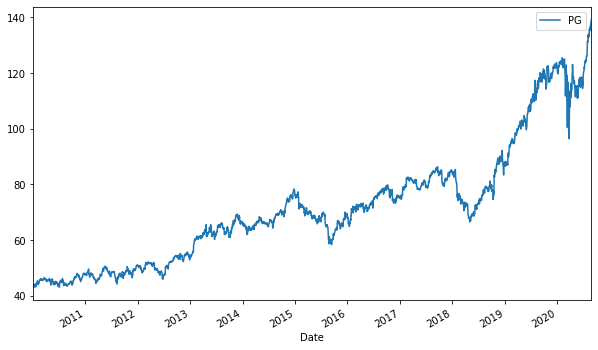

In [4]:
data.plot(figsize=(10, 6));
data.tail

Plot log returns

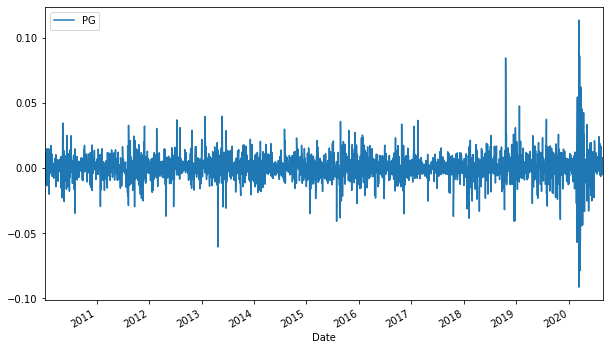

In [5]:
log_returns.plot(figsize = (10, 6));

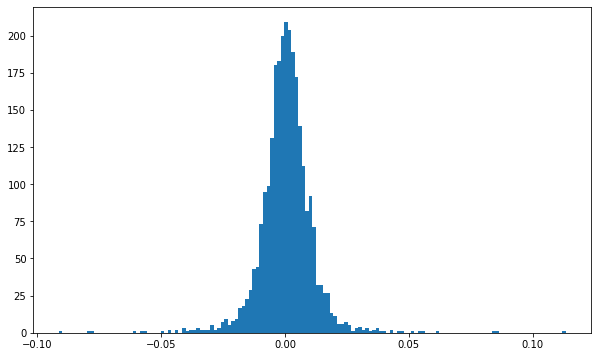

In [6]:
plt.figure(figsize=(10,6))
plt.hist(np_log_returns[1:], bins='auto');

find the mean

In [7]:
u = log_returns.mean()
u

PG    0.000431
dtype: float64

find the variance

In [8]:
var = log_returns.var()
var

PG    0.000118
dtype: float64

calculate the drift component for our geometric brownian motion model, mean - 1/2 variance

In [9]:
drift = u - (0.5 * var)
drift

PG    0.000373
dtype: float64

stddev of returns

In [10]:
stdev = log_returns.std()
stdev

PG    0.010845
dtype: float64

check that the types of our variables are pandas series

In [11]:
type(drift)

pandas.core.series.Series

In [12]:
type(stdev)

pandas.core.series.Series

convert pandas to np arrays

In [13]:
np.array(drift)

array([0.00037258])

In [14]:
drift.values

array([0.00037258])

works with stddev too

In [15]:
stdev.values

array([0.01084486])

function to find standard deviation of percent chance, for instance 95% chance (lower tail probability) is 1.65 standard deviations above the mean

In [16]:
norm.ppf(0.95)

1.6448536269514722

10x2 array of random numbers

In [17]:
x = np.random.rand(10, 2)
x

array([[0.96335085, 0.84699588],
       [0.70097483, 0.13440637],
       [0.68076764, 0.02051195],
       [0.12454597, 0.10368938],
       [0.9194298 , 0.91800168],
       [0.22072751, 0.77031853],
       [0.52097743, 0.52187362],
       [0.90084547, 0.11757223],
       [0.30341847, 0.31469138],
       [0.59622583, 0.01191473]])

pass the random numbers into the ppf function

In [18]:
norm.ppf(x)

array([[ 1.7909688 ,  1.02363389],
       [ 0.5272063 , -1.10580082],
       [ 0.46984644, -2.04328832],
       [-1.15255777, -1.26080595],
       [ 1.40124639,  1.39175487],
       [-0.7697385 ,  0.73989626],
       [ 0.05260686,  0.05485652],
       [ 1.28638406, -1.18721085],
       [-0.51459375, -0.48259581],
       [ 0.24359005, -2.25986768]])

call this a random variable denoted $Z$

In [19]:
Z = norm.ppf(np.random.rand(10,2))
Z

array([[-1.54670177,  0.46091342],
       [ 0.28133712, -0.60574904],
       [-0.62116443,  0.51415234],
       [ 0.36541145, -0.77276694],
       [ 0.76803252,  0.1011557 ],
       [ 0.91667486,  0.31561171],
       [-0.20541436,  1.68626461],
       [ 0.25106621,  0.21426926],
       [ 0.27625855, -0.55719554],
       [ 0.97572562, -0.73049787]])

variables for the simulation

`t_intervals` is the number of days in the future

`iterations` is the number of times to simulate

In [20]:
t_intervals = 30
iterations = 1000000

matrix of daily returns = $e^{\text{drift} + \text{stddev} \cdot Z}$

In [21]:
daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))
daily_returns

array([[0.98686   , 1.01341877, 0.99959423, ..., 0.9951491 , 1.00055458,
        1.00410917],
       [0.99758398, 0.99724241, 0.99667855, ..., 1.00345135, 1.00895754,
        1.01525479],
       [0.98928425, 0.98577724, 1.00171408, ..., 0.97912884, 1.01421085,
        1.00641313],
       ...,
       [1.01234251, 0.99720676, 1.00322492, ..., 1.0161148 , 1.01083866,
        0.98454506],
       [1.01565989, 1.0144869 , 1.01255366, ..., 0.99264131, 1.00710983,
        1.01270062],
       [1.00912027, 1.0036086 , 0.99842994, ..., 1.00065952, 0.9937356 ,
        0.99440653]])

Each row represents a day, each column represents a simulation. The values are the daily returns for that day and simulation. $S_{t+1} = S_{t-1} \cdot r$. We set $S_0$ equal to the current stock price.

In [22]:
S0 = data.iloc[-1]
S0

PG    139.059998
Name: 2020-08-25 00:00:00, dtype: float64

create a new array with the same dimentions as `daily returns`

In [23]:
price_list = np.zeros_like(daily_returns)
price_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

set the first row (first day) of the simulation equal to the current price

In [24]:
price_list[0] = S0
price_list

array([[139.05999756, 139.05999756, 139.05999756, ..., 139.05999756,
        139.05999756, 139.05999756],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

simulate each day

In [25]:
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

did it work?

In [26]:
price_list

array([[139.05999756, 139.05999756, 139.05999756, ..., 139.05999756,
        139.05999756, 139.05999756],
       [138.72402521, 138.67652644, 138.59811608, ..., 139.53994264,
        140.30563259, 141.18132907],
       [137.23749335, 136.7041639 , 138.83568419, ..., 136.62758211,
        142.29949459, 142.08674291],
       ...,
       [146.82698725, 131.50873768, 142.94465185, ..., 130.67725238,
        151.88419571, 139.98353576],
       [149.12628176, 133.41389217, 144.73912974, ..., 129.7156396 ,
        152.96406666, 141.7614136 ],
       [150.48635309, 133.89532981, 144.51188112, ..., 129.80118978,
        152.00583792, 140.96847475]])

plot the iterations if there aren't too many

In [27]:
if iterations <= 10000:
    plt.figure(figsize=(10,6))
    plt.plot(price_list);

the final prices after `t_intervals` days for each iteration

In [28]:
final_prices = price_list[-1]
final_prices

array([150.48635309, 133.89532981, 144.51188112, ..., 129.80118978,
       152.00583792, 140.96847475])

a histogram of the prices after `t_intervals` days

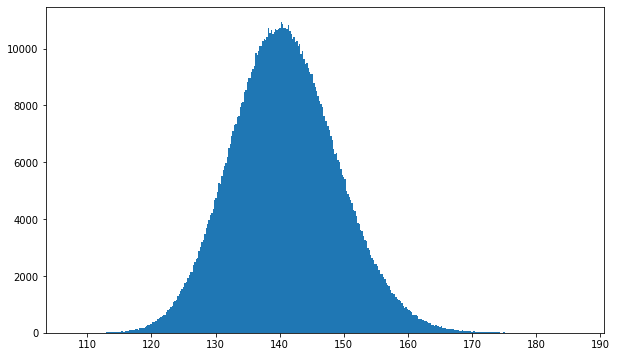

In [29]:
plt.figure(figsize=(10,6))
plt.hist(final_prices, bins='auto');

calculate the cumulative probability that the stock will be between two values

In [30]:
lb = 140
lb_inclusive = True
ub = -1
ub_inclusive = False

total_prices = 0
counted = 0
for price in final_prices:
    lb_condition = lb == -1 or price > lb
    ub_condition = ub == -1 or price < ub
    if lb_condition and ub_condition:
        counted += 1
    elif lb_inclusive and price == lb:
        counted += 1
    elif ub_inclusive and price == ub:
        counted += 1
    total_prices += 1

counted / total_prices

0.0

class to represent a bundle of option contracts with a function to calculate the p/l at a given price

In [31]:
class OptionsStrategy:
    def __init__(self, contracts):
        self.contracts = contracts
        
    def reward(self, mkt):
        credit = -0.015 * len(self.contracts)

        for contract in self.contracts:
            if contract[0] == "LONG":
                credit -= contract[2]
                if contract[1] == "CALL" and mkt > contract[3]:
                    credit += mkt - contract[3]
                elif contract[1] == "PUT" and mkt < contract[3]:
                    credit += contract[3] - mkt
                elif contract[1] == "STOCK":
                    credit += mkt - contract[3]
            elif contract[0] == "SHORT":
                credit += contract[2]
                if contract[1] == "CALL" and mkt > contract[3]:
                    credit -= mkt - contract[3]
                elif contract[1] == "PUT" and mkt < contract[3]:
                    credit -= contract[3] - mkt

        return credit

test a strategy

In [41]:
# ("LONG", "CALL", premium, strike)

trial_strategy = OptionsStrategy([
    ("SHORT", "PUT", 2.70, 145),
    ("LONG", "PUT", 0.0, 140),
])

plot the profit/loss diagram and breakeven point

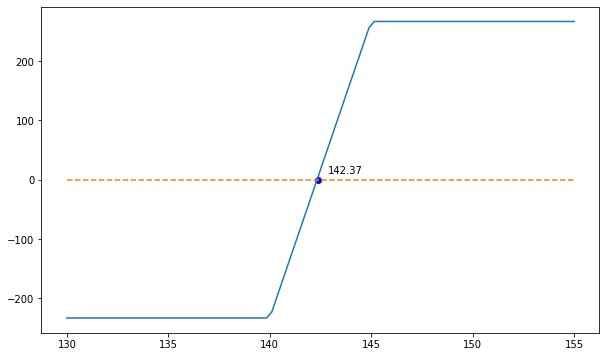

In [42]:
plt.figure(figsize=(10,6))
x = np.linspace(130, 155, 100)
breakeven_pl = 100
breakeven_price = 0
y = []
for xi in x:
    reward_i = trial_strategy.reward(xi) * 100
    y.append(reward_i)
    if abs(reward_i) < breakeven_pl:
        breakeven_price = xi
        breakeven_pl = abs(reward_i)
plt.annotate("{:.2f}".format(breakeven_price), (breakeven_price + 0.5, 10))
plt.plot(breakeven_price, 0, 'bo')
plt.plot(x, y);
plt.plot(x, [0]*len(x), '--');

calculate ev of the strategy

In [43]:
granularity = len(final_prices)

ev = 0
max_risk = 0
prob_success = 0
for price in final_prices:
    reward = trial_strategy.reward(price) * 100
    ev += reward / granularity
    if reward > 0:
        prob_success += 1
    if -1 * reward > max_risk:
        max_risk = -1 * reward
    
ev

-28.391908218638545

capital risked

In [44]:
max_risk

233.0

expected return on capital risked

In [45]:
ev / max_risk

-0.12185368334179633

probability of success

In [46]:
prob_success / granularity

0.415367